# Data Profiling: Gender Wage Gap

Source of data: https://www.oecd.org/en/data/indicators/gender-wage-gap.html

## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from ydata_profiling import ProfileReport

In [2]:
raw_data_path = "../data/01_gender_wage_gap/raw/OECD.ELS.SAE,DSD_EARNINGS@GENDER_WAGE_GAP,+all.csv"
output_path = "../data/01_gender_wage_gap/preprocessed/GENDER_WAGE_GAP.csv"

report_path = "reports/01_data_profile_gender_wage_gap.html"

## Load and inspect data

In [3]:
df = pd.read_csv(raw_data_path)
df.head(2)

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Reference area,MEASURE,Measure,UNIT_MEASURE,Unit of measure,...,OBS_VALUE,Observation value,BASE_PER,Base period,OBS_STATUS,Observation status,UNIT_MULT,Unit multiplier,DECIMALS,Decimals
0,DATAFLOW,OECD.ELS.SAE:DSD_EARNINGS@GENDER_WAGE_GAP(1.1),Gender wage gap,I,AUS,Australia,GWP,Gender wage gap,PT_WG_SAL_M_D,Percentage of wages of men in the same decile,...,0.0,NaN,NaN,NaN,A,Normal value,0,Units,1,One
1,DATAFLOW,OECD.ELS.SAE:DSD_EARNINGS@GENDER_WAGE_GAP(1.1),Gender wage gap,I,CHL,Chile,GWP,Gender wage gap,PT_WG_SAL_M_D,Percentage of wages of men in the same decile,...,0.0,NaN,NaN,NaN,A,Normal value,0,Units,1,One


### Shape and date types

In [4]:
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")

Dataset has 3894 rows and 30 columns


In [5]:
dict(df.dtypes)

{'STRUCTURE': dtype('O'),
 'STRUCTURE_ID': dtype('O'),
 'STRUCTURE_NAME': dtype('O'),
 'ACTION': dtype('O'),
 'REF_AREA': dtype('O'),
 'Reference area': dtype('O'),
 'MEASURE': dtype('O'),
 'Measure': dtype('O'),
 'UNIT_MEASURE': dtype('O'),
 'Unit of measure': dtype('O'),
 'PAY_PERIOD': dtype('O'),
 'Pay period': dtype('O'),
 'PRICE_BASE': dtype('O'),
 'Price base': dtype('O'),
 'AGGREGATION_OPERATION': dtype('O'),
 'Aggregation operation': dtype('O'),
 'SEX': dtype('O'),
 'Sex': dtype('O'),
 'TIME_PERIOD': dtype('int64'),
 'Time period': dtype('float64'),
 'OBS_VALUE': dtype('float64'),
 'Observation value': dtype('float64'),
 'BASE_PER': dtype('float64'),
 'Base period': dtype('float64'),
 'OBS_STATUS': dtype('O'),
 'Observation status': dtype('O'),
 'UNIT_MULT': dtype('int64'),
 'Unit multiplier': dtype('O'),
 'DECIMALS': dtype('int64'),
 'Decimals': dtype('O')}

### Missing values

In [6]:
df.isna().sum()[df.isna().sum() > 0] * 100 / df.shape[0]

Time period          100.000000
OBS_VALUE              0.077042
Observation value    100.000000
BASE_PER             100.000000
Base period          100.000000
dtype: float64

In [7]:
# Drop entirely null columns
df.drop(columns=["Time period", "Observation value", "BASE_PER", "Base period"], inplace=True)

count    3891.000000
mean       17.958503
std        10.190620
min       -27.385038
25%        10.922868
50%        17.480871
75%        23.546133
max        63.041013
Name: OBS_VALUE, dtype: float64

<Axes: >

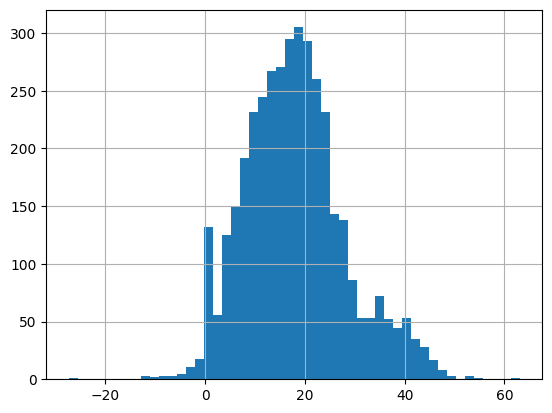

In [8]:
# Look also for zeros
# Values that are exactly zero are unlikely, so they are most likely in fact missing data

display(df["OBS_VALUE"].describe())
df["OBS_VALUE"].hist(bins=50)

In [9]:
df_zeros = df[df["OBS_VALUE"] == 0]
display(df_zeros.groupby(["Reference area", "TIME_PERIOD"], as_index=False)["OBS_VALUE"].count().sort_values("OBS_VALUE"))
display(df_zeros.groupby(["Reference area"], as_index=False)["OBS_VALUE"].count().sort_values("OBS_VALUE"))

,Reference area,TIME_PERIOD,OBS_VALUE
0,Australia,1996,1
1,Brazil,2012,1
3,Brazil,2014,1
4,Brazil,2015,1
5,Brazil,2016,1
...,...,...,...
84,Türkiye,2018,1
7,Brazil,2018,2
2,Brazil,2013,2
6,Brazil,2017,2


,Reference area,OBS_VALUE
0,Australia,1
2,Bulgaria,1
3,Chile,1
6,Finland,1
15,Switzerland,1
14,Romania,1
11,Lithuania,1
8,Iceland,1
10,Latvia,2
5,Czechia,2


In [10]:
# Create a copy of this column with the zeros set to NA
target = "Pct of wages of men in the same decile"

df[target] = df["OBS_VALUE"]
df.loc[df[target] == 0, target] = pd.NA

In [11]:
a = df.isna().sum()[df.isna().sum() > 0]
print(a)
print(a * 100 / df.shape[0])

OBS_VALUE                                  3
Pct of wages of men in the same decile    92
dtype: int64
OBS_VALUE                                 0.077042
Pct of wages of men in the same decile    2.362609
dtype: float64


### Numerical features

In [12]:
num_cols = ["TIME_PERIOD", "UNIT_MULT", "DECIMALS", "OBS_VALUE", target]
df[num_cols].describe()

,TIME_PERIOD,UNIT_MULT,DECIMALS,OBS_VALUE,Pct of wages of men in the same decile
count,3894.000000,3894.0,3894.0,3891.000000,3802.000000
mean,2007.796097,0.0,1.0,17.958503,18.378889
std,11.808082,0.0,0.0,10.190620,9.927340
min,1970.000000,0.0,1.0,-27.385038,-27.385038
25%,2001.000000,0.0,1.0,10.922868,11.425872
50%,2010.000000,0.0,1.0,17.480871,17.724910
75%,2018.000000,0.0,1.0,23.546133,23.689057
max,2024.000000,0.0,1.0,63.041013,63.041013


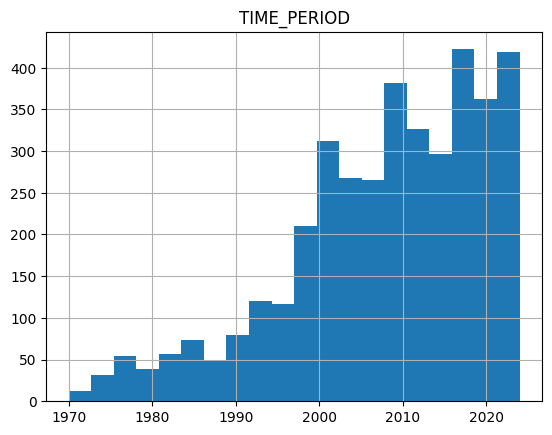

,count,mean,std,min,25%,50%,75%,max
TIME_PERIOD,3894.0,2007.796097,11.808082,1970.0,2001.0,2010.0,2018.0,2024.0


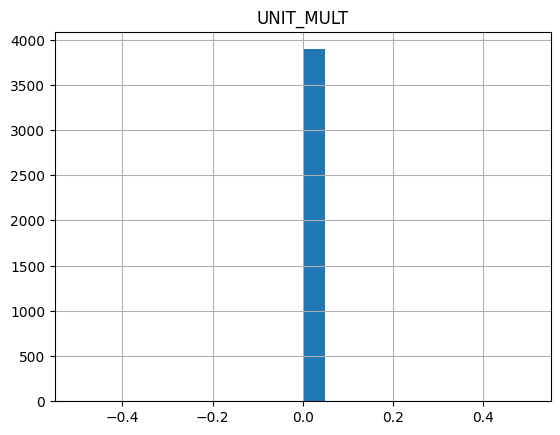

,count,mean,std,min,25%,50%,75%,max
UNIT_MULT,3894.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


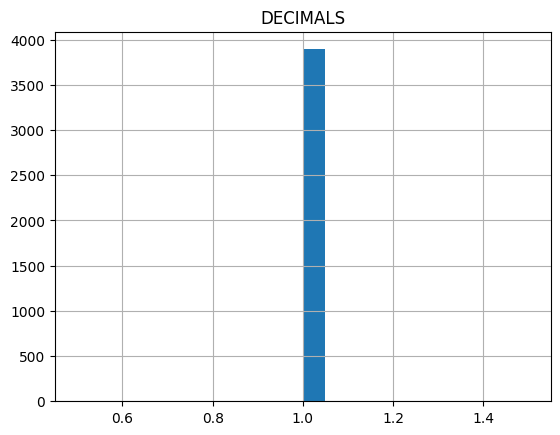

,count,mean,std,min,25%,50%,75%,max
DECIMALS,3894.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


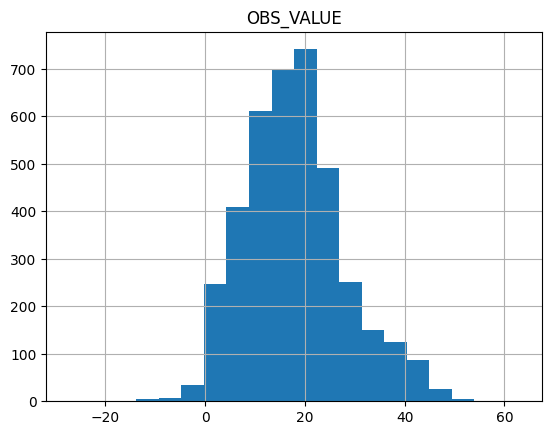

,count,mean,std,min,25%,50%,75%,max
OBS_VALUE,3891.0,17.958503,10.19062,-27.385038,10.922868,17.480871,23.546133,63.041013


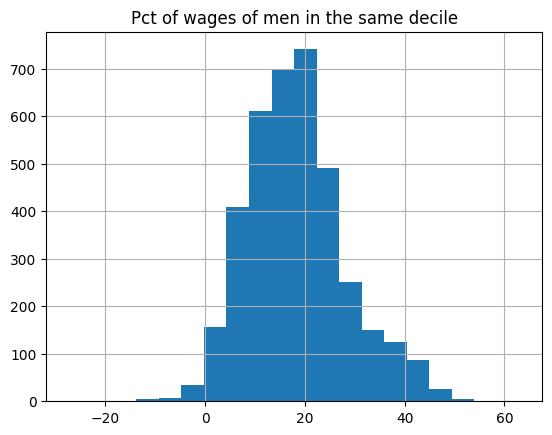

,count,mean,std,min,25%,50%,75%,max
Pct of wages of men in the same decile,3802.0,18.378889,9.92734,-27.385038,11.425872,17.72491,23.689057,63.041013


In [13]:
for col in num_cols:
    df[col].hist(bins=20)
    plt.title(col)
    plt.show()
    display(df[[col]].describe().T)

In [14]:
df[["UNIT_MULT", "DECIMALS"]].nunique()

UNIT_MULT    1
DECIMALS     1
dtype: int64

In [15]:
# Drop columns that contain a single constant
df.drop(columns=["UNIT_MULT", "DECIMALS"], inplace=True)

### Text and categorical features

In [16]:
cat_cols = [
    "STRUCTURE",
    "STRUCTURE_ID",
    "STRUCTURE_NAME",
    "ACTION",
    "REF_AREA",
    "Reference area",
    "MEASURE",
    "Measure",
    "UNIT_MEASURE",
    "Unit of measure",
    "PAY_PERIOD",
    "Pay period",
    "PRICE_BASE",
    "Price base",
    "AGGREGATION_OPERATION",
    "Aggregation operation",
    "SEX",
    "Sex",
    "OBS_STATUS",
    "Observation status",
    "Unit multiplier",
    "Decimals"
]
df[cat_cols].describe().T

,count,unique,top,freq
STRUCTURE,3894,1,DATAFLOW,3894
STRUCTURE_ID,3894,1,OECD.ELS.SAE:DSD_EARNINGS@GENDER_WAGE_GAP(1.1),3894
STRUCTURE_NAME,3894,1,Gender wage gap,3894
ACTION,3894,1,I,3894
REF_AREA,3894,50,GBR,220
Reference area,3894,50,United Kingdom,220
MEASURE,3894,1,GWP,3894
Measure,3894,1,Gender wage gap,3894
UNIT_MEASURE,3894,1,PT_WG_SAL_M_D,3894
Unit of measure,3894,1,Percentage of wages of men in the same decile,3894


In [17]:
# Drop columns which contain a single constant
df.drop(columns=["STRUCTURE", "STRUCTURE_ID", "STRUCTURE_NAME", "ACTION", "MEASURE", "Measure", "UNIT_MEASURE", "Unit of measure", "PAY_PERIOD", "Pay period", "PRICE_BASE", "Price base", "SEX", "Sex", "OBS_STATUS", "Observation status", "Unit multiplier", "Decimals"], inplace=True)

In [18]:
cat_cols_1 = ["REF_AREA", "Reference area"]
cat_cols_2 = ["AGGREGATION_OPERATION", "Aggregation operation"]

display(df[cat_cols_1].drop_duplicates().sort_values(by=cat_cols_1))
display(df[cat_cols_2].drop_duplicates())

,REF_AREA,Reference area
860,ARG,Argentina
0,AUS,Australia
138,AUT,Austria
158,BEL,Belgium
87,BGR,Bulgaria
74,BRA,Brazil
183,CAN,Canada
68,CHE,Switzerland
1,CHL,Chile
224,COL,Colombia


,AGGREGATION_OPERATION,Aggregation operation
0,MEAN,Mean
1,D9,Decile 9
10,D1,Decile 1
2645,MEDIAN,Median


In [19]:
# Drop duplicate column
df.drop(columns=["AGGREGATION_OPERATION"], inplace=True)

### Review dataset

In [20]:
df.head()

,REF_AREA,Reference area,Aggregation operation,TIME_PERIOD,OBS_VALUE,Pct of wages of men in the same decile
0,AUS,Australia,Mean,1996,0.0,NaN
1,CHL,Chile,Decile 9,2006,0.0,NaN
2,CRI,Costa Rica,Decile 9,2011,0.0,NaN
3,CRI,Costa Rica,Decile 9,2016,0.0,NaN
4,CRI,Costa Rica,Decile 9,2020,0.0,NaN


In [21]:
df_agg = df.groupby(by=["TIME_PERIOD", "Reference area"], as_index=False).agg({"Aggregation operation": ("count", "nunique", list)})
df_agg

TIME_PERIOD  Reference area Aggregation operation          \
                                                 count nunique   
0           1970  United Kingdom                     4       4   
1           1971  United Kingdom                     4       4   
2           1972  United Kingdom                     4       4   
3           1973  United Kingdom                     4       4   
4           1973   United States                     4       4   
...          ...             ...                   ...     ...   
1012        2024     New Zealand                     4       4   
1013        2024          Norway                     4       4   
1014        2024          Sweden                     4       4   
1015        2024  United Kingdom                     4       4   
1016        2024   United States                     4       4   

                                          
                                    list  
0     [Decile 1, Decile 9, Mean, Median]  
1     [Decile 1, Decile 9, Mean, Median]  
2     [Decile 1, Decile 9, Mean, Median]  
3     [Decile 1, Decile 9, Mean, Median]  
4     [Decile 1, Decile 9, Mean, Median]  
...                                  ...  
1012  [Decile 1, Decile 9, Mean, Median]  
1013  [Decile 1, Decile 9, Mean, Median]  
1014  [Decile 1, Decile 9, Mean, Median]  
1015  [Decile 1, Decile 9, Mean, Median]  
1016  [Decile 1, Decile 9, Mean, Median]  

[1017 rows x 5 columns]

In [22]:
df_agg = df.groupby(by=["Reference area"], as_index=False).agg({"TIME_PERIOD": ("min", "max", "count")})
df_agg

Reference area TIME_PERIOD            
                                                  min   max count
0                               Argentina        2017  2024    32
1                               Australia        1975  2024   197
2                                 Austria        2000  2023    88
3                                 Belgium        1999  2023    99
4                                  Brazil        2012  2024    49
5                                Bulgaria        2002  2023    26
6                                  Canada        1997  2024   112
7                                   Chile        1998  2023    52
8                                Colombia        2007  2024    70
9                              Costa Rica        2010  2024    58
10                                Croatia        2010  2023    20
11                                 Cyprus        2002  2023    28
12                                Czechia        1996  2024   110
13                                Denmark        2002  2023    88
14                                Estonia        2002  2023    28
15  European Union (19 countries) in OECD        1995  2023   116
16          European Union (27 countries)        1995  2023   116
17                                Finland        1977  2023   172
18                                 France        2002  2023    28
19                                Germany        1992  2023   128
20                                 Greece        2002  2023    28
21                                Hungary        1986  2023   130
22                                Iceland        2002  2022    22
23                                  India        2018  2024    28
24                                Ireland        2002  2023    28
25                                 Israel        2001  2022    88
26                                  Italy        2002  2023    28
27                                  Japan        1975  2024   200
28                                  Korea        1984  2024   143
29                                 Latvia        2002  2023    28
30                              Lithuania        2002  2023    25
31                             Luxembourg        2002  2022    27
32                                  Malta        2002  2023    37
33                                 Mexico        2005  2024    74
34                            Netherlands        2002  2023    28
35                            New Zealand        1984  2024   149
36                                 Norway        1997  2024   112
37                                   OECD        1995  2023   116
38                                   Peru        2010  2022    48
39                                 Poland        1980  2023   104
40                               Portugal        2002  2023    28
41                                Romania        2002  2023    36
42                        Slovak Republic        2002  2023    88
43                               Slovenia        2002  2023    28
44                                  Spain        2002  2023    28
45                                 Sweden        1992  2024   123
46                            Switzerland        1996  2023    59
47                                Türkiye        2006  2018    16
48                         United Kingdom        1970  2024   220
49                          United States        1973  2024   208

In [23]:
df[df[target].isna()][["Reference area", "TIME_PERIOD", "Aggregation operation"]]

,Reference area,TIME_PERIOD,Aggregation operation
0,Australia,1996,Mean
1,Chile,2006,Decile 9
2,Costa Rica,2011,Decile 9
3,Costa Rica,2016,Decile 9
4,Costa Rica,2020,Decile 9
...,...,...,...
87,Bulgaria,2006,Decile 1
88,Romania,2010,Decile 1
3887,Luxembourg,2015,Median
3888,Luxembourg,2016,Median


### Attempt to impute missing values based on linear regression

In [24]:
def plot_time_series(df, area, year, target=target):
    df.sort_values(by="TIME_PERIOD", inplace=True)

    cut = (df["Reference area"] == area) & (df["TIME_PERIOD"] >= year)

    for op in ("Median", "Decile 1", "Decile 9", "Mean"):
        plt.plot(
            df[cut & (df["Aggregation operation"] == op)]["TIME_PERIOD"],
            df[cut & (df["Aggregation operation"] == op)][target],
            label=op
        )

    plt.title(area)
    plt.legend()
    plt.show()

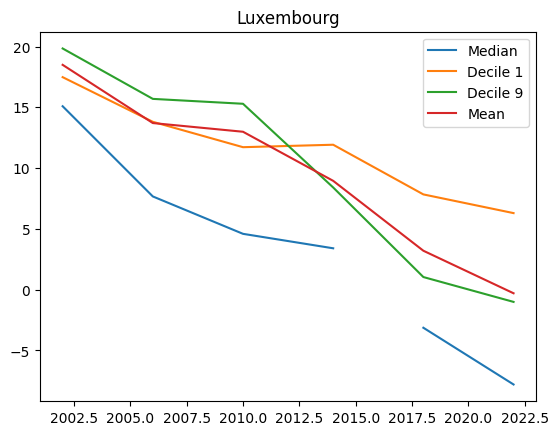

In [25]:
plot_time_series(df, "Luxembourg", 1970, "OBS_VALUE")

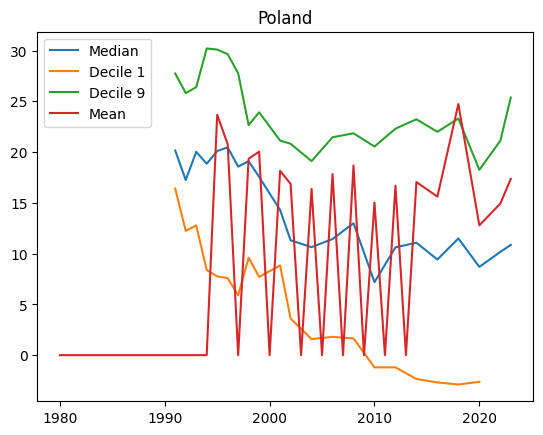

In [26]:
plot_time_series(df, "Poland", 1970, "OBS_VALUE")

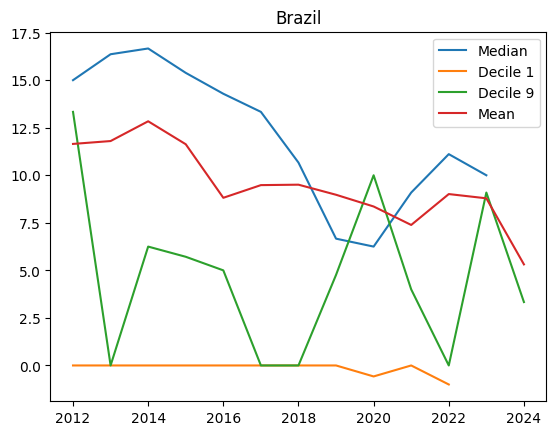

In [27]:
plot_time_series(df, "Brazil", 1970, "OBS_VALUE")

In [28]:
def impute_or_drop_missing_values(df, area, metric):
    cut = (df["Reference area"] == area) & (df["Aggregation operation"] == metric)
    cut_na = df[target].isna()

    df_train = df[cut & (~cut_na)]

    if df_train.shape[0] > 0:
        model = LinearRegression(fit_intercept=True)
        model.fit(df_train[["TIME_PERIOD"]], df_train[target])
        df.loc[cut & cut_na, target] = model.predict(df.loc[cut & cut_na, ["TIME_PERIOD"]])
    else:
        to_drop = df.loc[cut & cut_na]
        print(f"Dropping {to_drop.shape[0]} rows for {area} / {metric}...")
        df = df.loc[~cut | (cut & (~cut_na))]

    return df

In [29]:
for _, (area, metric) in df[df[target].isna()][["Reference area", "Aggregation operation"]].drop_duplicates().iterrows():
    df = impute_or_drop_missing_values(df, area, metric)

Dropping 4 rows for Türkiye / Decile 1...


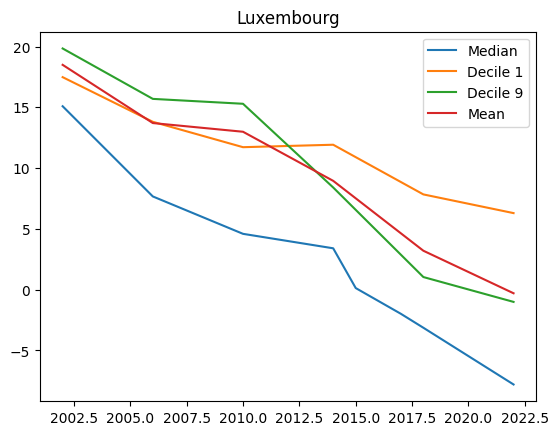

In [30]:
plot_time_series(df, "Luxembourg", 1970)

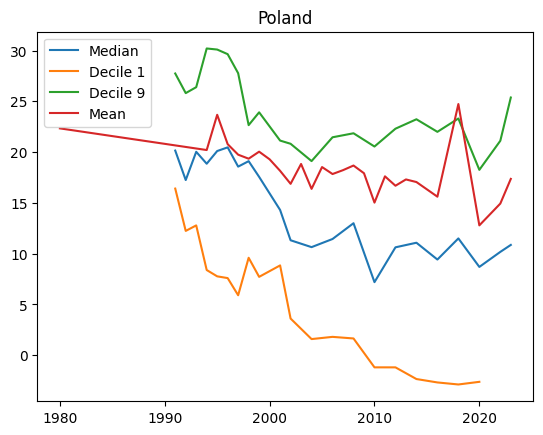

In [31]:
plot_time_series(df, "Poland", 1970)

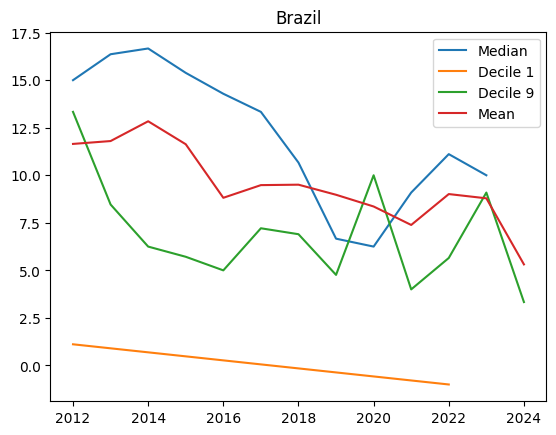

In [32]:
plot_time_series(df, "Brazil", 1970)

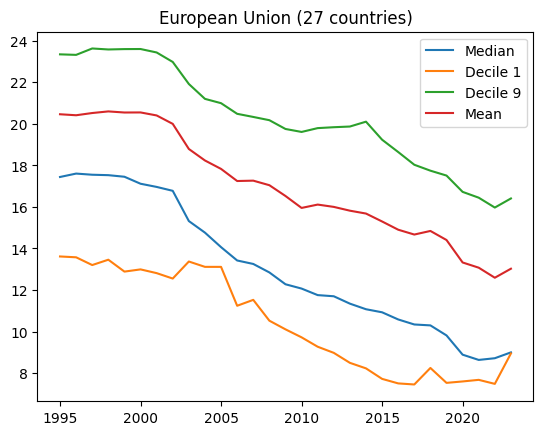

In [33]:
plot_time_series(df, "European Union (27 countries)", 1970)

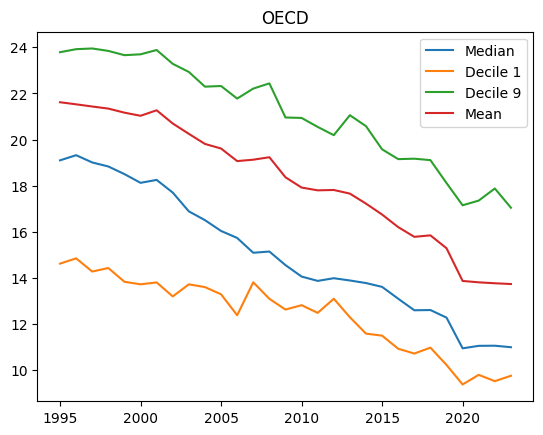

In [34]:
plot_time_series(df, "OECD", 1970)

**Summary:**

* The dataset contains observations of the percentage of wages that women make in relation to men in the same decile
* The granularity of the data is: yearly observations per (global) geographical area and aggregation metric
  * Areas are either an individual country or a group of countries (OECD, EU - 19 countries, EU - 27 countries)
  * Data includes a total of 50 areas
  * Years range from 1970 to 2024
  * Available years vary from area to area (most only start in the late 90s/early 00s)
  * Provided metrics are: mean, median, decile 1, decile 9
* There are 92 rows (2.36% of all data) with missing observations:
  * 3 of these rows are actual missing data, the others contain zeros which are most likely missing data
  * These were imputed using a linear regression with the appropriate granularity level (area + metric)
  * Dropped 4 rows for Turkey / decile 1, which could not be imputed
* Dropped multiple columns that were either empty or contained a constant value

## Generate profiling report

In [35]:
profile = ProfileReport(df, title="Gender wage gap dataset")
profile.to_file(report_path)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 477.82it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Save data

In [36]:
df.to_csv(output_path, index=False)